
# Selenium image Data Scraping + Generative Adverserial Networks for images 

This notebook contains Selenium web scraping script to collect the data that will be used by the GAN Model to generate images. GAN model is also set up, so you can tweak hyperparameters and start training the networks right away. If you follow the notebook, the data scraped from web will be normalized (if resolutions of downloaded images are greater than the value that you set for normalization) and prepared in a dataset.

For a hint on what kind of results can be achieved, check at the end of the notebook to see how networks learned to generate anime character images (note: this was done on a dataset of 10000+ images)

In [1]:
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.python.keras import backend as K
K.clear_session()
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
import time
import PIL
import imageio
import glob
import cv2
import os
import numpy as np

In [3]:
import selenium
from selenium import webdriver
import time
import requests
import os
from PIL import Image
import io
import hashlib

# Put the path for your ChromeDriver here
DRIVER_PATH = f"C:\\Program Files (x86)\\chromedriver.exe"


def fetch_image_urls(query:str, max_links_to_fetch:int, wd:webdriver, sleep_between_interactions:int=1):
    def scroll_to_end(wd):
        wd.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(sleep_between_interactions)    
    
    # build the google query
    search_url = "https://www.google.com/search?safe=on&site=&tbm=isch&source=hp&q={q}&oq={q}&gs_l=img"

    # load the page
    wd.get(search_url.format(q=query))

    image_urls = set()
    image_count = 0
    results_start = 0
    while image_count < max_links_to_fetch:
        scroll_to_end(wd)

        # get all image thumbnail results
        thumbnail_results = wd.find_elements_by_css_selector("img.Q4LuWd")
        number_results = len(thumbnail_results)
        
        print(f"Found: {number_results} search results. Extracting links from {results_start}:{number_results}")
        
        for img in thumbnail_results[results_start:number_results]:
            # try to click every thumbnail such that we can get the real image behind it
            try:
                img.click()
                time.sleep(sleep_between_interactions)
            except Exception:
                continue

            # extract image urls    
            actual_images = wd.find_elements_by_css_selector('img.n3VNCb')
            for actual_image in actual_images:
                if actual_image.get_attribute('src') and 'http' in actual_image.get_attribute('src'):
                    image_urls.add(actual_image.get_attribute('src'))

            image_count = len(image_urls)

            if len(image_urls) >= max_links_to_fetch:
                print(f"Found: {len(image_urls)} image links, done!")
                break
        else:
            print("Found:", len(image_urls), "image links, looking for more ...")
            time.sleep(30)
            return
            load_more_button = wd.find_element_by_css_selector(".mye4qd")
            if load_more_button:
                wd.execute_script("document.querySelector('.mye4qd').click();")

        # move the result startpoint further down
        results_start = len(thumbnail_results)

    return image_urls

def persist_image(folder_path:str,file_name:str,url:str):
    try:
        image_content = requests.get(url).content

    except Exception as e:
        print(f"ERROR - Could not download {url} - {e}")

    try:
        image_file = io.BytesIO(image_content)
        image = Image.open(image_file).convert('RGB')
        folder_path = os.path.join(folder_path,file_name)
        if os.path.exists(folder_path):
            file_path = os.path.join(folder_path,hashlib.sha1(image_content).hexdigest()[:10] + '.jpg')
        else:
            os.mkdir(folder_path)
            file_path = os.path.join(folder_path,hashlib.sha1(image_content).hexdigest()[:10] + '.jpg')
        with open(file_path, 'wb') as f:
            image.save(f, "JPEG", quality=85)
        print(f"SUCCESS - saved {url} - as {file_path}")
    except Exception as e:
        print(f"ERROR - Could not save {url} - {e}")

if __name__ == '__main__':
    wd = webdriver.Chrome(executable_path=DRIVER_PATH)
    queries = ["guitar"]  #change desired image search string(s) here
    for query in queries:
        wd.get('https://google.com')
        search_box = wd.find_element_by_css_selector('input.gLFyf')
        search_box.send_keys(query)
        links = fetch_image_urls(query,100,wd)
        #images_path = '/Users/anand/Desktop/contri/images'  #enter your desired image path
        images_path = 'F:\google_scrape'
        for i in links:
            persist_image(images_path,query,i)
    wd.quit()

Found: 100 search results. Extracting links from 0:100
Found: 101 image links, done!
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRT6fWV2sl_X3wNtjdQYUP7w5gRZyuWpoNz3A&usqp=CAU - as F:\google_scrape\guitar\d081c58ccd.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS-3TLrN0dm0nYWmdc1RsArd0ma2wmO_SoE8g&usqp=CAU - as F:\google_scrape\guitar\4d14314d21.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRmTpMg3lCk7woj5zP78jMXY3zk3RuNvwO8Xw&usqp=CAU - as F:\google_scrape\guitar\e836f15b9b.jpg
SUCCESS - saved https://giggear.2dimg.com/1/1547744962_5197.jpg - as F:\google_scrape\guitar\814509e608.jpg
SUCCESS - saved https://www.sigma-guitars.com/wp-content/uploads/2021/03/Start-Sigma-Web-1.jpg - as F:\google_scrape\guitar\38681edd0c.jpg
SUCCESS - saved https://upload.wikimedia.org/wikipedia/commons/4/45/GuitareClassique5.png - as F:\google_scrape\guitar\735c72ea92.jpg
SUCCESS - saved https://static.sonovente.com/img/libra

C:\Users\ajdin\anaconda3\envs\datascience\lib\site-packages\PIL\Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


SUCCESS - saved https://takelessons.com/blog/wp-content/uploads/2013/12/Anatomy-of-the-Guitar.png - as F:\google_scrape\guitar\6f8e91bec6.jpg
SUCCESS - saved https://thumbs.static-thomann.de/thumb/orig/pics/bdb/255975/15521705_800.jpg - as F:\google_scrape\guitar\e681ff270a.jpg
SUCCESS - saved https://online.berklee.edu/takenote/wp-content/uploads/2020/07/learn_acoustic_blues_guitar_article_image.jpg - as F:\google_scrape\guitar\53b5565ecb.jpg
SUCCESS - saved https://images.squarespace-cdn.com/content/v1/5b7d8ac7697a988b951bdc95/1611728210677-016BGGS79ZRHB96CKQS3/image-9.jpg?format=2500w - as F:\google_scrape\guitar\feed5b745f.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQuLE2K0LydRUEw68HzZjTYr1-PvmTzdXtWhw&usqp=CAU - as F:\google_scrape\guitar\c378e346c3.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTiuSKw_L9DlsRDhBn3mB5wdFo_cK2XcV9DmQ&usqp=CAU - as F:\google_scrape\guitar\4e3f10f245.jpg
SUCCESS - saved https://encrypted-tbn0.gs

C:\Users\ajdin\anaconda3\envs\datascience\lib\site-packages\PIL\Image.py:2929: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


ERROR - Could not save https://www.businesscoot.com/uploads/study_main_image/227.webp - cannot identify image file <_io.BytesIO object at 0x00000298991F2AC8>
SUCCESS - saved https://cdn.cnn.com/cnnnext/dam/assets/210406115217-istock-1128247331-live-video.jpg - as F:\google_scrape\guitar\c442f74461.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTn5Vq37RSDlXbWkYd7SQRxr3hLPCOOEFM1BQ&usqp=CAU - as F:\google_scrape\guitar\223954ae30.jpg
SUCCESS - saved https://img.kytary.com/eshop_ie/velky_v2/na/637299957869830000/1a862cc9/64763211/kohala-full-size-steel-string-acoustic-guitar.jpg - as F:\google_scrape\guitar\c8f9572b9d.jpg
SUCCESS - saved https://www.collingsguitars.com/img/home/cj-45-t-header.jpg - as F:\google_scrape\guitar\6d368844bd.jpg
SUCCESS - saved https://cdn.alzashop.com/ImgW.ashx?fd=f16&cd=CASCH004 - as F:\google_scrape\guitar\0c0b0410bf.jpg
SUCCESS - saved https://www.soundpure.com/a/wp-content/uploads/2018/04/The-Parts-of-an-Acoustic-Guitar.jpg - as 

In [4]:
from IPython import display

In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7150165867382239865
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5077532672
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15493676530507787500
physical_device_desc: "device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:06:00.0, compute capability: 6.1"
]


In [6]:
#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.3)
#sess = tf.Session(config=tf.ConfigProto(
 # allow_soft_placement=True, log_device_placement=True))

In [7]:

#path = r"F:\google_scrape\Sebilj"

In [8]:
BUFFER_SIZE = 600000
BATCH_SIZE = 260

In [9]:
path = r"F:\google_scrape\Guitar"

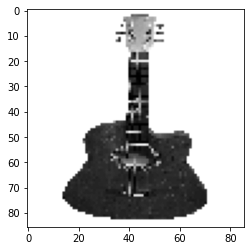

In [10]:

for img in os.listdir(path):
    img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
    img_array = cv2.resize(img_array, (86, 86))
    plt.imshow(img_array, cmap="gray")
    plt.show()
    break

In [11]:
anime = []
def data_generator():
    counter = 0  
    
    for img in os.listdir(path):
        counter = counter + 1
        if counter < 100:
            try:
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                normalized_array = cv2.resize(img_array, (84, 84))
                anime.append(normalized_array)
            except Exception as e:
                pass
        else:
            pass

In [12]:
data_generator()

In [13]:
anime = np.array(anime)

In [14]:
anime[3]

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

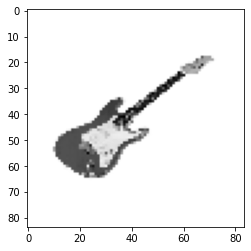

In [15]:
plt.imshow(anime[7], cmap="gray")

In [16]:
anime.shape

(99, 84, 84)

In [17]:
anime = anime.reshape(anime.shape[0], 84, 84, 1).astype('float32')
anime = (anime - 127.5) / 127.5

In [18]:
anime = tf.data.Dataset.from_tensor_slices(anime).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [19]:
#train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [20]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(3, 3), padding='same', use_bias=False))
    assert model.output_shape == (None, 21, 21, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 42, 42, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 84, 84, 1)

    return model

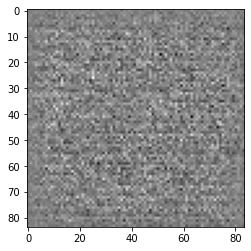

In [21]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

Here is the correct formula for computing the size of the output with tf.layers.conv2d_transpose():

# Padding==Same:
H = H1 * stride

# Padding==Valid
H = (H1-1) * stride + HF
where, H = output size, H1 = input size, HF = height of filter

In [22]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same',
                                     input_shape=[84, 84, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (6, 6), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [23]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00098516]], shape=(1, 1), dtype=float32)


In [24]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [25]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [26]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [27]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [28]:
import os
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                               generator=generator,
                                discriminator=discriminator)

In [48]:
EPOCHS = 500
noise_dim = 100
num_examples_to_generate = 16


# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [35]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [36]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        print(str(epoch)+ " epoch started ")
        for image_batch in dataset:
            train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed)

In [37]:

def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

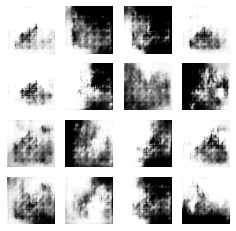

In [38]:

train(anime, EPOCHS)

In [39]:
checkpoint.save(file_prefix = checkpoint_prefix)

'./training_checkpoints\\ckpt-1'

In [40]:
#checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [56]:
from PIL import Image

    

In [44]:
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

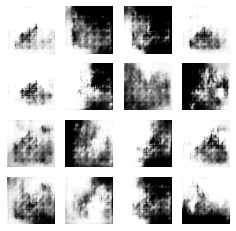

In [45]:
generate_and_save_images(generator,
                           EPOCHS,
                         
                           (seed))

In [46]:
seed2 = tf.random.normal([1, noise_dim])

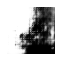

In [47]:
generate_and_save_images(generator, EPOCHS, (seed2))

In [37]:
seed

<tf.Tensor: shape=(16, 100), dtype=float32, numpy=
array([[-0.00310293, -0.5936633 , -0.4749485 , ..., -0.6838559 ,
         0.01484823,  1.4633857 ],
       [-1.0610524 , -0.5710774 ,  0.9399171 , ...,  0.33721873,
        -0.8639653 ,  1.3803271 ],
       [ 0.0379644 ,  1.5611299 , -1.2587653 , ..., -0.5416663 ,
         0.543342  , -0.3916941 ],
       ...,
       [-0.3090632 ,  1.09004   , -1.1134189 , ..., -0.1917316 ,
         0.192573  ,  0.54181325],
       [-0.02014506, -0.11677801,  0.3821605 , ...,  0.7509932 ,
         1.7056667 ,  0.7107994 ],
       [-0.4244393 ,  0.35286254, -1.6010844 , ...,  0.26581612,
         0.58535814, -0.569768  ]], dtype=float32)>

In [34]:
anim_file = 'dcgan1.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)


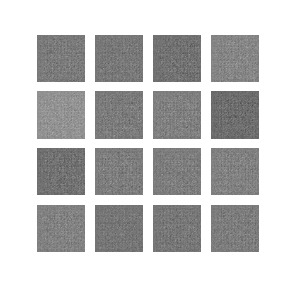

In [35]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

In [65]:
imagos = generator((seed), training=False)

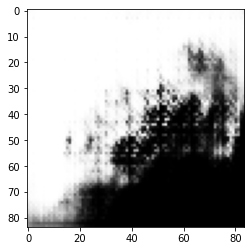

In [83]:
plt.imshow(imagos[11], cmap="gray")


# Sample Results (Anime Character Face Generation)

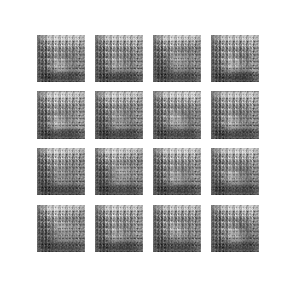

In [100]:
from IPython.display import Image
Image("0.png")

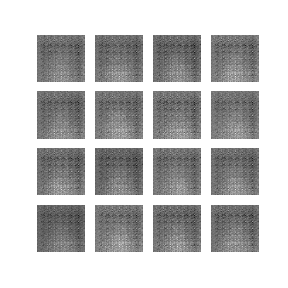

In [89]:
Image("1.png")

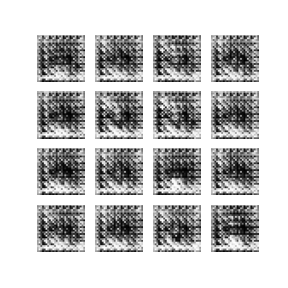

In [93]:
Image("3.png")

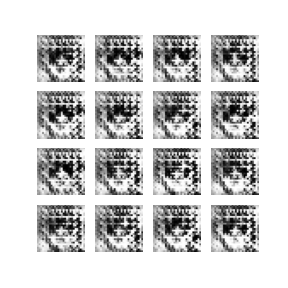

In [92]:
Image("2.png")

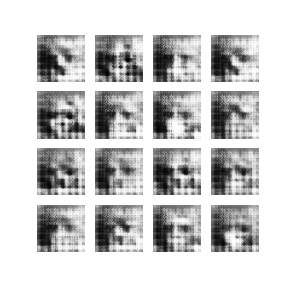

In [94]:
Image("4.png")

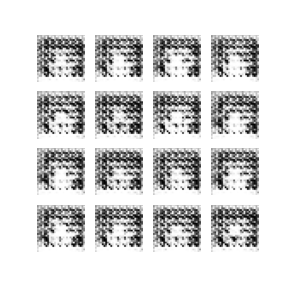

In [95]:
Image("5.png")

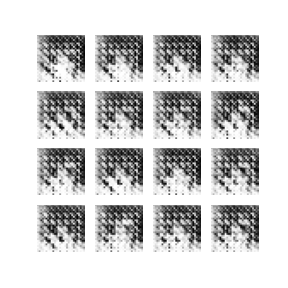

In [96]:
Image("6.png")

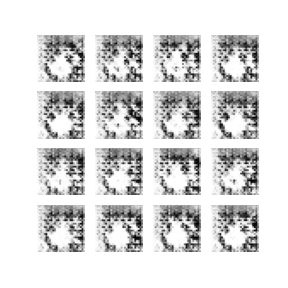

In [97]:
Image("7.png")

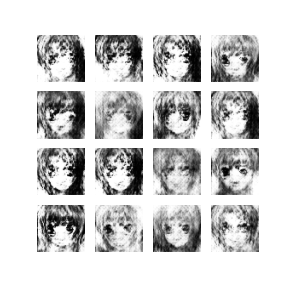

In [98]:
Image("8.png")

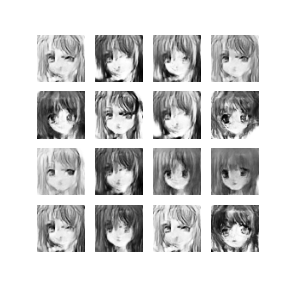

In [99]:
Image("Anime legitovac.png")